In [589]:
import pandas as pd
import numpy as np
#from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from datetime import date
import time
plt.style.use('ggplot')

In [346]:
#read the csv into a pandas dataframe
df = pd.read_csv('/Users/raffi/Desktop/galvanize/capstone_1/data/games.csv', delimiter = ',')

In [347]:
#dropping duplicated ids in dataframe
df.drop_duplicates(subset = ['id'], inplace = True)

In [348]:
#update moves column from string to list for future analysis
df.moves = df.moves.apply(lambda x: x.split(' '))

In [349]:
#categorize rating scale - 1517 below 1200, 12668 between 1400 - 2000, 1716 above 2000
#https://en.wikipedia.org/wiki/Chess_rating_system
#https://en.wikipedia.org/wiki/Elo_rating_system
#beginner < 1400 : 4729
#novice 1200 - 1999 : 12668
#expert 2000 - 2200 : 1169
#master > 2200 : 547

#df[(df['white_rating'] >= 2000) & (df['white_rating'] < 2200)].count()
#df[df['white_rating'] >= 2200].count()
#df[df['white_rating'] < 1400].count()

#categorize rating scales
def rating_cat_value(val):
    if val < 1400:
        return 'Beginner'
    elif val < 2000:
        return 'Novice'
    elif val < 2200:
        return 'Expert'
    elif val >= 2200:
        return 'Master'
    
def rating_cat_code(val):
    if val < 1400:
        return 1
    elif val < 2000:
        return 2
    elif val < 2200:
        return 3
    elif val >= 2200:
        return 4

df['white_rating_value'] = df['white_rating'].apply(rating_cat_value)
df['black_rating_value'] = df['black_rating'].apply(rating_cat_value)
df['white_rating_code'] = df['white_rating'].apply(rating_cat_code)
df['black_rating_code'] = df['black_rating'].apply(rating_cat_code)

In [442]:
#creating new column for main opening line - used to filter through variations
def opening_strip(opening):
    if ':' in opening:
        opening = opening.split(':')[0]
    while '|' in opening:
        opening = opening.split('|')[0]
    if '#' in opening:
        opening = opening.split('#')[0]
    if 'Accepted' in opening:
        opening = opening.replace('Accepted', '')
    if 'Declined' in opening:
        opening = opening.replace('Declined', '')
    if 'Refused' in opening:
        opening = opening.replace('Refused', '')
    return opening.strip()

df['main_opening'] = df['opening_name'].apply(opening_strip)

In [350]:
#adding new column of data - date
date = pd.to_datetime(df['created_at'], errors = 'ignore', unit = 'ms')
df['date'] = pd.DatetimeIndex(date).date

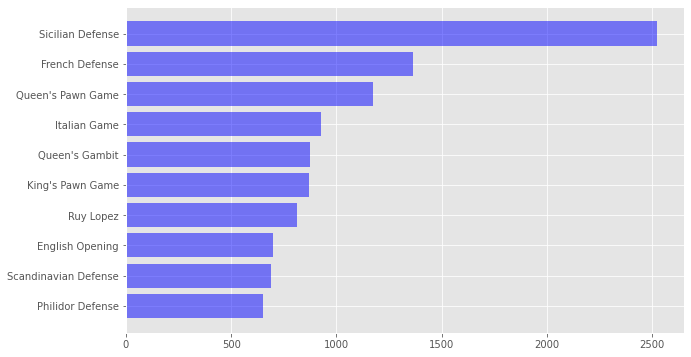

In [443]:
#top 10 openings
openings = df['main_opening'].value_counts()
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings.index[0:10]]
arr = np.array(openings[0:10])
ax.barh(x_pos, arr, color = 'b', alpha = 0.5)
ax.set_ylim(ax.get_ylim()[::-1]);

In [446]:
openings_grouped = df.groupby(['main_opening', 'white_rating_value'])['id'].count()
openings_grouped = pd.DataFrame(openings_grouped).reset_index()
openings_grouped = openings_grouped.pivot(index = 'main_opening', columns = 'white_rating_value', values = 'id')
openings_grouped.fillna(0, inplace = True)
openings_grouped['total'] = openings_grouped['Beginner'] + openings_grouped['Expert'] + openings_grouped['Novice'] + openings_grouped['Master']
openings_grouped.sort_values(by = 'total', ascending = False, inplace = True)
openings_grouped[0:10]

white_rating_value,Beginner,Expert,Master,Novice,total
main_opening,,,,,
Sicilian Defense,402.0,191.0,103.0,1830.0,2526.0
French Defense,292.0,77.0,32.0,962.0,1363.0
Queen's Pawn Game,332.0,57.0,30.0,753.0,1172.0
Italian Game,198.0,42.0,22.0,664.0,926.0
Queen's Gambit,153.0,75.0,24.0,625.0,877.0
King's Pawn Game,434.0,5.0,3.0,429.0,871.0
Ruy Lopez,140.0,74.0,33.0,565.0,812.0
English Opening,134.0,68.0,24.0,473.0,699.0
Scandinavian Defense,245.0,46.0,13.0,384.0,688.0


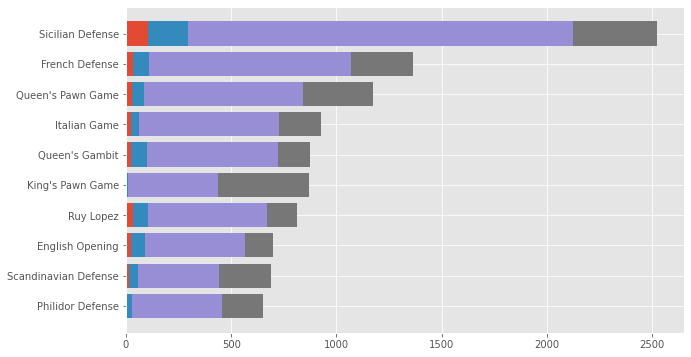

In [447]:
#top 10 most frequent openings played by ranking group
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:10]]
b = np.array(openings_grouped['Beginner'][0:10])
n = np.array(openings_grouped['Novice'][0:10])
e = np.array(openings_grouped['Expert'][0:10])
m = np.array(openings_grouped['Master'][0:10])
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1]);

In [448]:
openings_grouped.sort_values(by = 'Master', ascending = False, inplace = True)
openings_grouped

white_rating_value,Beginner,Expert,Master,Novice,total
main_opening,,,,,
Sicilian Defense,402.0,191.0,103.0,1830.0,2526.0
Ruy Lopez,140.0,74.0,33.0,565.0,812.0
French Defense,292.0,77.0,32.0,962.0,1363.0
Queen's Pawn Game,332.0,57.0,30.0,753.0,1172.0
Caro-Kann Defense,100.0,50.0,26.0,385.0,561.0
...,...,...,...,...,...
Gunderam Defense,4.0,1.0,0.0,6.0,11.0
Paleface Attack,4.0,0.0,0.0,6.0,10.0
Petrov,2.0,1.0,0.0,6.0,9.0


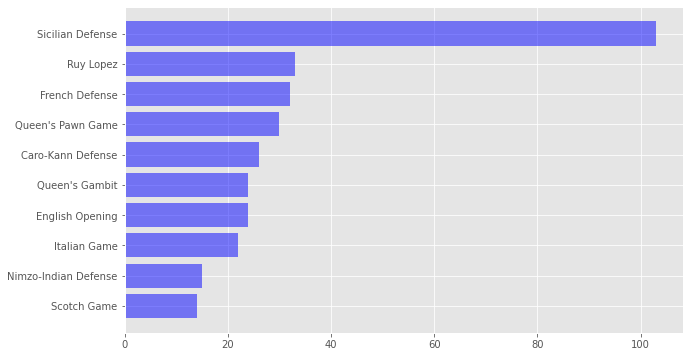

In [449]:
#top 10 openings for masters
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:10]]
arr = np.array(openings_grouped['Master'][0:10])
ax.barh(x_pos, arr, color = 'b', alpha = 0.5)
ax.set_ylim(ax.get_ylim()[::-1]);

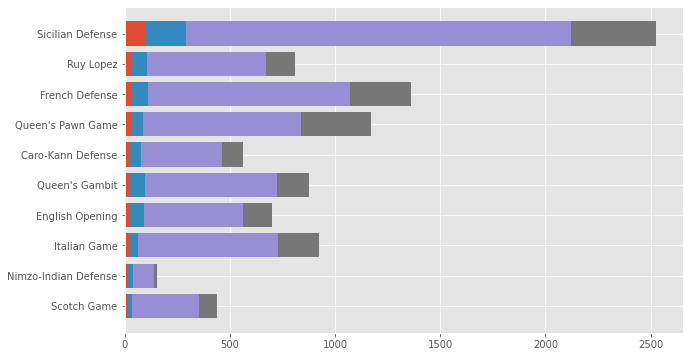

In [450]:
#top 10 most frequent master openings played by ranking group
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:10]]
b = np.array(openings_grouped['Beginner'][0:10])
n = np.array(openings_grouped['Novice'][0:10])
e = np.array(openings_grouped['Expert'][0:10])
m = np.array(openings_grouped['Master'][0:10])
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1]);

In [452]:
openings_grouped['Beginner_%'] = openings_grouped['Beginner'] / openings_grouped['Beginner'].sum()
openings_grouped['Expert_%'] = openings_grouped['Expert'] / openings_grouped['Expert'].sum()
openings_grouped['Master_%'] = openings_grouped['Master'] / openings_grouped['Master'].sum()
openings_grouped['Novice_%'] = openings_grouped['Novice'] / openings_grouped['Novice'].sum()
openings_grouped[0:10]

white_rating_value,Beginner,Expert,Master,Novice,total,Beginner_%,Expert_%,Master_%,Novice_%
main_opening,,,,,,,,,
Sicilian Defense,402.0,191.0,103.0,1830.0,2526.0,0.085007,0.163388,0.188300,0.144458
Ruy Lopez,140.0,74.0,33.0,565.0,812.0,0.029605,0.063302,0.060329,0.044601
French Defense,292.0,77.0,32.0,962.0,1363.0,0.061747,0.065868,0.058501,0.075939
Queen's Pawn Game,332.0,57.0,30.0,753.0,1172.0,0.070205,0.048760,0.054845,0.059441
Caro-Kann Defense,100.0,50.0,26.0,385.0,561.0,0.021146,0.042772,0.047532,0.030392
Queen's Gambit,153.0,75.0,24.0,625.0,877.0,0.032354,0.064157,0.043876,0.049337
English Opening,134.0,68.0,24.0,473.0,699.0,0.028336,0.058169,0.043876,0.037338
Italian Game,198.0,42.0,22.0,664.0,926.0,0.041869,0.035928,0.040219,0.052416
Nimzo-Indian Defense,11.0,25.0,15.0,101.0,152.0,0.002326,0.021386,0.027422,0.007973


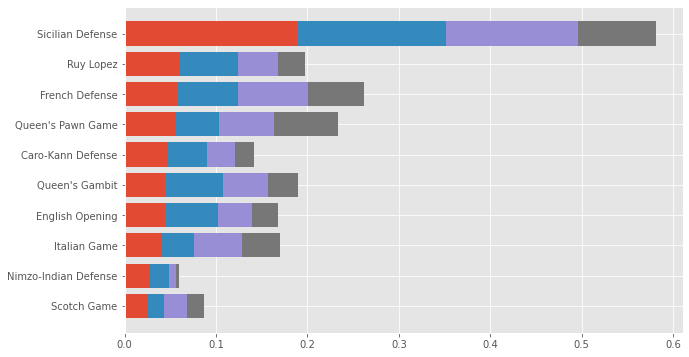

In [453]:
#top 10 master openings % played by group
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:10]]
b = np.array(openings_grouped['Beginner_%'][0:10])
n = np.array(openings_grouped['Novice_%'][0:10])
e = np.array(openings_grouped['Expert_%'][0:10])
m = np.array(openings_grouped['Master_%'][0:10])
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1]);

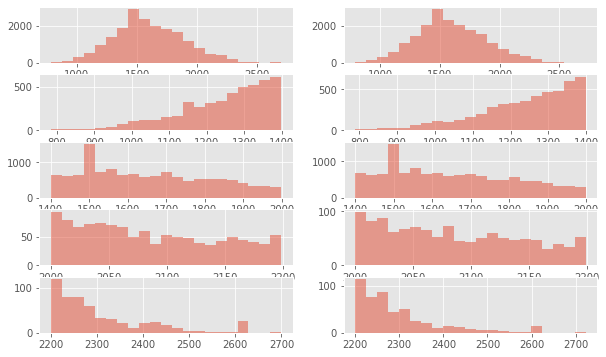

In [359]:
#distribution of ratings by group
fig,axs = plt.subplots(5,2, figsize = (10,6))
bins = 21
wb = df[df['white_rating_value'] == 'Beginner']
wn = df[df['white_rating_value'] == 'Novice']
we = df[df['white_rating_value'] == 'Expert']
wm = df[df['white_rating_value'] == 'Master']
bb = df[df['black_rating_value'] == 'Beginner']
bn = df[df['black_rating_value'] == 'Novice']
be = df[df['black_rating_value'] == 'Expert']
bm = df[df['black_rating_value'] == 'Master']
axs[0,0].hist(df['white_rating'], bins, alpha = 0.5)
axs[1,0].hist(wb['white_rating'], bins, alpha = 0.5)
axs[2,0].hist(wn['white_rating'], bins, alpha = 0.5)
axs[3,0].hist(we['white_rating'], bins, alpha = 0.5)
axs[4,0].hist(wm['white_rating'], bins, alpha = 0.5)
axs[0,1].hist(df['black_rating'], bins, alpha = 0.5)
axs[1,1].hist(bb['black_rating'], bins, alpha = 0.5)
axs[2,1].hist(bn['black_rating'], bins, alpha = 0.5)
axs[3,1].hist(be['black_rating'], bins, alpha = 0.5)
axs[4,1].hist(bm['black_rating'], bins, alpha = 0.5);

In [360]:
wb_dist = stats.norm(wb['white_rating'].mean(), wb['white_rating'].std())
wn_dist = stats.norm(wn['white_rating'].mean(), wn['white_rating'].std())
we_dist = stats.norm(we['white_rating'].mean(), we['white_rating'].std())
wm_dist = stats.norm(we['white_rating'].mean(), wm['white_rating'].std())

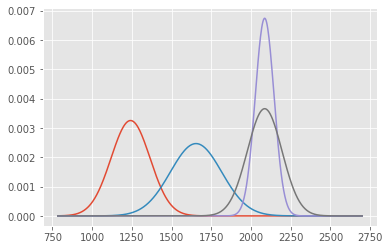

In [361]:
#distributions of white rating by category
fig, ax = plt.subplots(1,1, figsize = (6,4))
x = np.linspace(df['white_rating'].min(), df['white_rating'].max(), 501)
plt.plot(x, wb_dist.pdf(x))
plt.plot(x, wn_dist.pdf(x))
plt.plot(x, we_dist.pdf(x))
plt.plot(x, wm_dist.pdf(x))

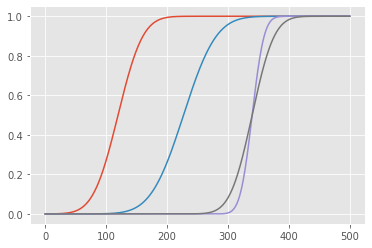

In [362]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
x = np.linspace(df['white_rating'].min(), df['white_rating'].max(), 501)
plt.plot(wb_dist.cdf(x))
plt.plot(wn_dist.cdf(x))
plt.plot(we_dist.cdf(x))
plt.plot(wm_dist.cdf(x));

In [463]:
date_grouping = df.groupby(['date', 'main_opening'])['id'].count()
date_grouping = pd.DataFrame(date_grouping).reset_index()
date_grouping = date_grouping.pivot(index = 'date', columns = 'main_opening', values = 'id')
date_grouping.fillna(0, inplace = True)
date_grouping.sort_values(by = 'date', ascending = True, inplace = True)
date_grouping

main_opening,Alekhine Defense,Amar Opening,Amazon Attack,Anderssen Opening,Australian Defense,Barnes Defense,Barnes Opening,Benko Gambit,Benoni Defense,Bird Opening,...,Trompowsky Attack,Valencia Opening,Van Geet Opening,Van't Kruijs Opening,Vienna Game,Wade Defense,Ware Defense,Ware Opening,Yusupov-Rubinstein System,Zukertort Opening
date,,,,,,,,,,,,,,,,,,,,,
2013-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-09-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,9.0,...,0.0,0.0,1.0,6.0,4.0,0.0,0.0,0.0,2.0,11.0
2017-09-01,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,...,3.0,0.0,3.0,4.0,2.0,0.0,1.0,1.0,0.0,7.0
2017-09-02,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,...,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,6.0


In [364]:
wm_grouping = df.groupby(['opening_name', 'black_rating_value'])['id'].count()
wm_grouping = pd.DataFrame(wm_grouping).reset_index()
wm_grouping = wm_grouping.pivot(index = 'opening_name', columns = 'black_rating_value', values = 'id')
wm_grouping.fillna(0, inplace = True)
wm_grouping.sort_values(by = 'Novice', ascending = False, inplace = True)

In [365]:
date_grouping = df.groupby(['date', 'opening_name'])['id'].count()
date_grouping = pd.DataFrame(date_grouping).reset_index()
date_grouping = date_grouping.pivot(index = 'date', columns = 'opening_name', values = 'id')
date_grouping.fillna(0, inplace = True)
date_grouping.sort_values(by = 'date', ascending = True, inplace = True)

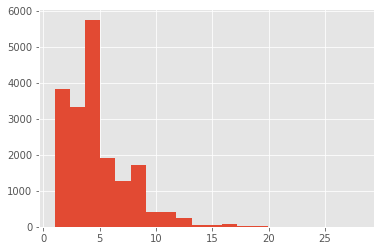

In [489]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.hist(df['opening_ply'], bins = 20 );

In [403]:
#EDA win rates
wins = df.groupby(['white_rating_value', 'black_rating_value', 'winner']).agg({'id': 'count','white_rating': 'mean', 'black_rating': 'mean', 'turns': 'mean', 'opening_ply': 'mean'})
wins

id  white_rating  \
white_rating_value black_rating_value winner                       
Beginner           Beginner           black   1332   1201.069069   
                                      draw     119   1208.344538   
                                      white   1449   1249.306418   
                   Expert             black     39   1264.384615   
                                      draw       1   1364.000000   
                                      white      4   1275.250000   
                   Master             black     26   1279.076923   
                   Novice             black   1209   1257.691481   
                                      draw      60   1302.483333   
                                      white    490   1288.859184   
Expert             Beginner           black      4   2043.500000   
                                      white     36   2081.777778   
                   Expert             black    177   2077.096045   
                                      draw      33   2094.424242   
                                      white    168   2101.732143   
                   Master             black     88   2095.829545   
                                      draw      10   2120.200000   
                                      white     43   2126.488372   
                   Novice             black    157   2066.471338   
                                      draw      22   2090.454545   
                                      white    431   2084.443155   
Master             Beginner           black      1   2277.000000   
                                      white     25   2382.960000   
                   Expert             black     39   2291.435897   
                                      draw      13   2277.923077   
                                      white    108   2285.009259   
                   Master             black     60   2287.183333   
                                      draw      18   2302.500000   
                                      white     56   2304.357143   
                   Novice             black     23   2328.000000   
                                      draw      15   2357.066667   
                                      white    189   2320.359788   
Novice             Beginner           black    431   1525.215777   
                                      draw      56   1547.982143   
                                      white   1432   1577.147346   
                   Expert             black    443   1780.528217   
                                      draw      34   1822.176471   
                                      white    150   1810.973333   
                   Master             black    165   1745.636364   
                                      draw       7   1791.857143   
                                      white     25   1753.760000   
                   Novice             black   4486   1639.959652   
                                      draw     500   1674.762000   
                                      white   4939   1678.650739   

                                              black_rating       turns  \
white_rating_value black_rating_value winner                             
Beginner           Beginner           black    1249.480480   54.263514   
                                      draw     1217.327731   74.991597   
                                      white    1199.350587   51.407177   
                   Expert             black    2088.333333   55.128205   
                                      draw     2081.000000   13.000000   
                                      white    2098.500000   51.000000   
                   Master             black    2336.307692   49.038462   
                   Novice             black    1583.878412   52.939620   
                                      draw     1514.000000   64.383333   
                                      white    1518.283673   55.300000   
Expert             Beginner    

In [404]:
wins_grouped = df.groupby(['white_rating_value', 'winner'])['id'].count()
wins_grouped = pd.DataFrame(wins_grouped).reset_index()
wins_grouped = wins_grouped.pivot(index = 'white_rating_value', columns = 'winner', values = 'id')
wins_grouped['total'] = wins_grouped['black'] + wins_grouped['white'] + wins_grouped['draw']
wins_grouped['white_%'] = wins_grouped['white'] / wins_grouped['total']
wins_grouped['black_%'] = wins_grouped['black'] / wins_grouped['total']
wins_grouped['draw_%'] = wins_grouped['draw'] / wins_grouped['total']
wins_grouped

winner,black,draw,white,total,white_%,black_%,draw_%
white_rating_value,,,,,,,
Beginner,2606,180,1943,4729,0.410869,0.551068,0.038063
Expert,426,65,678,1169,0.579983,0.364414,0.055603
Master,123,46,378,547,0.691042,0.224863,0.084095
Novice,5525,597,6546,12668,0.516735,0.436138,0.047127


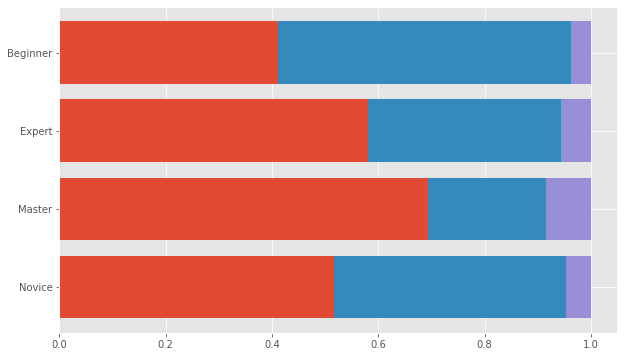

In [405]:
#percent win by ranking category
#need to shift
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in wins_grouped.index]
w = np.array(wins_grouped['white_%'])
b = np.array(wins_grouped['black_%'])
d = np.array(wins_grouped['draw_%'])

ax.barh(x_pos, w)
ax.barh(x_pos, b, left = w)
ax.barh(x_pos, d, left = w + b)

ax.set_ylim(ax.get_ylim()[::-1]);

In [482]:
master_vs_novice = df[(df['white_rating_value'] == 'Master') & (df['black_rating_value'] == 'Novice')]

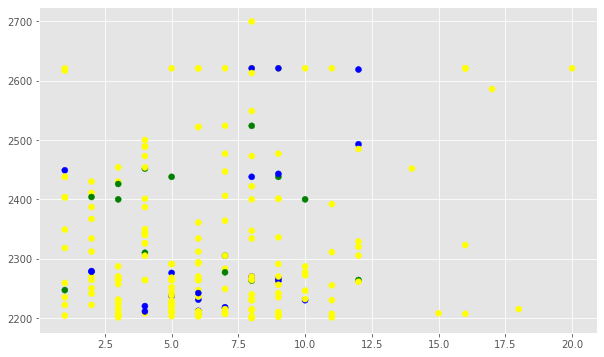

In [416]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
colors = {'white': 'yellow', 'black': 'blue', 'draw': 'green'}
ax.scatter(master_vs_novice['opening_ply'], master_vs_novice['white_rating'], c = master_vs_novice['winner'].map(colors))

In [422]:
otw = df[['white_rating', 'black_rating', 'turns', 'opening_ply']].copy()

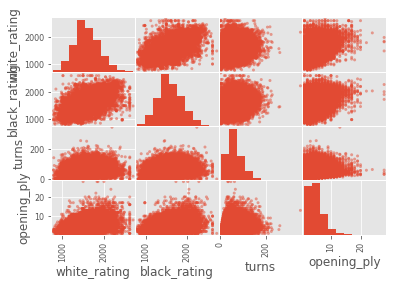

In [424]:
pd.plotting.scatter_matrix(otw);

In [464]:
total_wins = df.groupby(['winner', 'main_opening'])['id'].count()
total_wins = pd.DataFrame(total_wins).reset_index()
total_wins = total_wins.pivot(index = 'winner', columns = 'main_opening', values = 'id')
total_wins.fillna(0, inplace = True)
total_wins

main_opening,Alekhine Defense,Amar Opening,Amazon Attack,Anderssen Opening,Australian Defense,Barnes Defense,Barnes Opening,Benko Gambit,Benoni Defense,Bird Opening,...,Trompowsky Attack,Valencia Opening,Van Geet Opening,Van't Kruijs Opening,Vienna Game,Wade Defense,Ware Defense,Ware Opening,Yusupov-Rubinstein System,Zukertort Opening
winner,,,,,,,,,,,,,,,,,,,,,
black,75.0,6.0,3.0,7.0,0.0,4.0,0.0,9.0,29.0,74.0,...,11.0,1.0,32.0,210.0,56.0,1.0,4.0,14.0,10.0,118.0
draw,10.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,7.0,13.0,...,3.0,0.0,3.0,15.0,3.0,0.0,0.0,1.0,0.0,19.0
white,97.0,6.0,2.0,14.0,1.0,11.0,1.0,9.0,25.0,59.0,...,16.0,0.0,22.0,117.0,70.0,1.0,8.0,9.0,9.0,161.0


In [466]:
sicilian = df[df['main_opening'] == 'Sicilian Defense']

In [592]:
sicilian = df[df['main_opening'] == 'Sicilian Defense']
s = sicilian.groupby(['winner', 'black_rating_value'])['id'].count()
s = pd.DataFrame(s).reset_index()
s = s.pivot(index = 'black_rating_value', columns = 'winner', values = 'id')
s['total'] = s['black'] + s['draw'] + s['white']
s['win_%'] = s['black'] / s['total']
s['lose_%'] = s['white'] / s['total']
s['draw_%'] = s['draw'] / s['total']
s

winner,black,draw,white,total,win_%,lose_%,draw_%
black_rating_value,,,,,,,
Beginner,125,13,205,343,0.364431,0.597668,0.037901
Expert,134,16,81,231,0.580087,0.350649,0.069264
Master,65,7,26,98,0.663265,0.265306,0.071429
Novice,923,88,843,1854,0.497843,0.454693,0.047465


In [487]:
master_vs_novice['main_opening'].value_counts()[0:6]

Sicilian Defense     37
Ruy Lopez            17
Caro-Kann Defense    16
Queen's Gambit       14
English Opening      12
Italian Game         10
Name: main_opening, dtype: int64

In [506]:
def sicilian(main_opening):
    if main_opening == 'Sicilian Defense':
        return 1
    else:
        return 0

In [514]:
#master sicilian vs novice sicilian mean - t-test equal variance = false
black_masters = df[df['black_rating_value'] == 'Master'].copy()
black_novices = df[df['black_rating_value'] == 'Novice'].copy()
black_masters['sicilian'] = black_masters['main_opening'].apply(sicilian)
black_novices['sicilian'] = black_novices['main_opening'].apply(sicilian)

In [519]:
black_masters_mean = black_masters['sicilian'].sum() / black_masters['sicilian'].count()
black_novices_mean = black_novices['sicilian'].sum() / black_novices['sicilian'].count()
black_masters_mean, black_novices_mean

(0.19678714859437751, 0.14807124031626867)

In [527]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
ttest = stats.ttest_ind(black_masters['sicilian'], black_novices['sicilian'], equal_var = False)
ttest
#reject the null hypothesis of equal averages

Ttest_indResult(statistic=2.689444550967454, pvalue=0.00738306766431855)

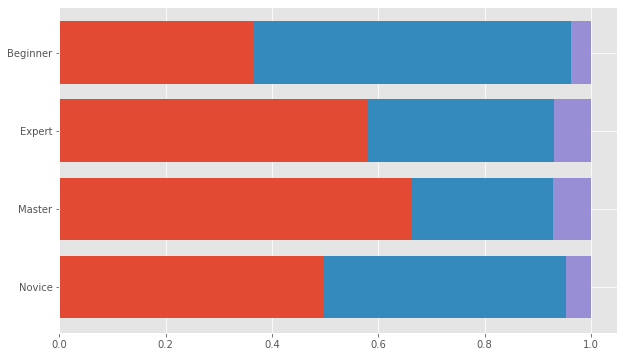

In [598]:
#percent sicilian win by ranking
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in s.index]
w = np.array(s['win_%'])
l = np.array(s['lose_%'])
d = np.array(s['draw_%'])

ax.barh(x_pos, w)
ax.barh(x_pos, l, left = w)
ax.barh(x_pos, d, left = w + l)

ax.set_ylim(ax.get_ylim()[::-1]);

In [603]:
sicilian_win = df[(df['main_opening'] == 'Sicilian Defense') & (df['winner'] == 'black')]
sicilian_loss = df[(df['main_opening'] == 'Sicilian Defense') & (df['winner'] == 'white')]
sicilian_draw = df[(df['main_opening'] == 'Sicilian Defense') & (df['winner'] == 'draw')]


pandas.core.frame.DataFrame

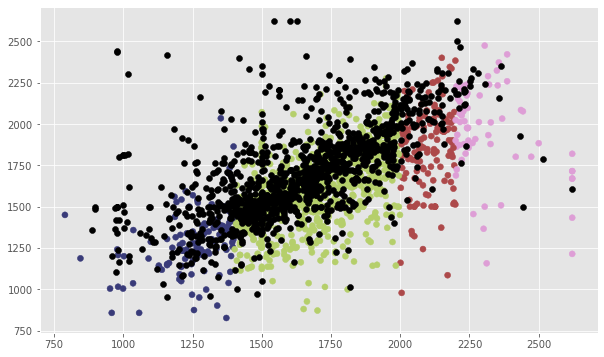

In [613]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.scatter(sicilian_win['black_rating'], sicilian_win['white_rating'], c = sicilian_win['black_rating_code'], cmap = 'tab20b')
ax.scatter(sicilian_loss['black_rating'], sicilian_loss['white_rating'], c = 'black')

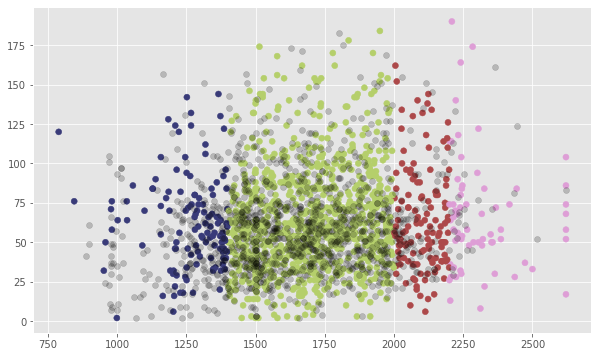

In [622]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.scatter(sicilian_win['black_rating'], sicilian_win['turns'], c = sicilian_win['black_rating_code'], cmap = 'tab20b')
ax.scatter(sicilian_loss['black_rating'], sicilian_loss['turns'], c = 'black', alpha = 0.2)

In [ ]:
#contingency table
# rows = master / novice
#columns = main_openings

In [672]:
cont_table = df[(df['main_opening'] == 'Sicilian Defense') | (df['main_opening'] == 'French Defense') | 
                (df['main_opening'] == 'Nimzo-Indian Defense') | (df['main_opening'] == 'Caro-Khann Defense')]
cont_table = cont_table.groupby(['main_opening', 'black_rating_value'])['id'].count()
cont_table = pd.DataFrame(cont_table).reset_index()
cont_table = cont_table.pivot(index = 'black_rating_value', columns = 'main_opening', values = 'id')
cont_table.fillna(0, inplace = True)
cont_table

main_opening,French Defense,Nimzo-Indian Defense,Sicilian Defense
black_rating_value,,,
Beginner,313,8,343
Expert,106,31,231
Master,32,18,98
Novice,912,95,1854


In [663]:
# cont_table.drop(index = 'Beginner', inplace = True)
# cont_table.drop(index = 'Expert', inplace = True)

In [675]:
cont_table

main_opening,French Defense,Nimzo-Indian Defense,Sicilian Defense
black_rating_value,,,
Beginner,313,8,343
Expert,106,31,231
Master,32,18,98
Novice,912,95,1854


In [674]:
stat, p, dof, expected = stats.chi2_contingency(cont_table)
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
prob, critical, stat
# alpha = 1 - prob
# p, alpha

(0.95, 12.591587243743977, 124.68676548321507)

In [ ]:
# contingency table
table = [	[10, 20, 30],
			[6,  9,  17]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')


In [ ]:
#man whitney test - don't need to make assumptions with variance and normality